### GAN Model v3

In [2]:
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from utils import split_sequence, get_apple_close_price, plot_series
from utils import plot_residual_forecast_error, print_performance_metrics
from utils import get_range, difference, inverse_difference
from utils import train_test_split, NN_walk_forward_validation

In [3]:
apple_close_price = get_apple_close_price()

In [4]:
short_series = get_range(apple_close_price, '2003-01-01')

In [5]:
# Model parameters
look_back = 5 # days window look back
n_features = 1 # our only feature will be Close price 
n_outputs = 1 # days forecast
batch_size = 32 # for NN, batch size before updating weights
n_epochs = 100 # for NN, number of training epochs

We need to first train/test split, then transform and scale our data

In [6]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox

In [7]:
train, test= train_test_split(apple_close_price,'2018-05-31')

In [8]:
boxcox_series, lmbda = boxcox(train.values)

In [11]:
transformed_train = boxcox_series
transformed_test = boxcox(test, lmbda=lmbda)

# transformed_train = train.values
# transformed_test = test.values

In [12]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
scaler = MinMaxScaler()

In [14]:
scaled_train = scaler.fit_transform(transformed_train.reshape(-1, 1))
scaled_test = scaler.transform(transformed_test.reshape(-1, 1))

In [15]:
X_train, y_train = split_sequence(scaled_train, look_back, n_outputs)
y_train = y_train.reshape(-1, n_outputs)

In [16]:
# Core layers
from keras.layers \
    import Activation, Dropout, Flatten, Dense, Input, LeakyReLU, Reshape

# Recurrent layers
from keras.layers import LSTM

# Convolutional layers
from keras.layers import Conv1D, MaxPooling1D

# Normalization layers
from keras.layers import BatchNormalization

# Merge layers
from keras.layers import concatenate

# Layer wrappers
from keras.layers import Bidirectional, TimeDistributed

# Keras models
from keras.models import Model, Sequential

# Keras optimizers
from keras.optimizers import Adam, RMSprop, SGD

import keras.backend as K

import warnings
warnings.simplefilter('ignore')

Using TensorFlow backend.


In [17]:
def build_generator(look_back, n_features=1, n_outputs=1):
    model = Sequential()

    model.add(LSTM(50, input_shape=(look_back, n_features)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(n_outputs))

    print('Generator summary:')
    model.summary()
    
    return model

In [33]:
def build_discriminator(look_back, n_features=1, n_outputs=1, optimizer=Adam()):
    features_input = Input((look_back, n_features))
    target_input = Input((1, n_outputs))
    
    x = Conv1D(64, 
               kernel_size=3, 
               padding='same')(features_input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Flatten()(x)

    y = Conv1D(64, 
               kernel_size=2, 
               padding='same')(target_input)
    y = LeakyReLU(alpha=0.2)(y)
    y = Flatten()(y)
    
    xy = concatenate([x, y])
    xy = Dense(64)(xy)
    xy = LeakyReLU(alpha=0.2)(xy)
    
    valid = Dense(1, activation='sigmoid')(xy)
    
    model = Model([features_input, target_input], valid);
    
    model.compile(loss='binary_crossentropy', optimizer=optimizer)

    print('Discriminator summary:')
    model.summary()
    
    return model

In [34]:
def build_adversarial(look_back, 
                      n_features=1, n_outputs=1, 
                      dis_optimizer=Adam(), adv_optimizer=Adam()):
    
    discriminator = build_discriminator(look_back, n_features, n_outputs, optimizer=dis_optimizer)
    generator = build_generator(look_back, n_features, n_outputs)
    
    seq = Sequential()
    seq.add(generator)
    
    gen_input = Input((look_back, n_features))
    gen_output = seq(gen_input)
    gen_output = Reshape((1, n_outputs))(gen_output)
    
    valid = discriminator([gen_input, gen_output])
    
    model = Model(gen_input, valid)
    
    discriminator.trainable = False # We need to freeze the discriminator's weights
    model.compile(loss='binary_crossentropy', optimizer=adv_optimizer)
    
    print('Adversarial summary:')
    model.summary()
    
    return model, discriminator, generator

In [35]:
adversarial, discriminator, generator = build_adversarial(look_back, 
                                                          n_features, 
                                                          n_outputs, 
                                                          dis_optimizer=Adam(lr=0.00001), 
                                                          adv_optimizer=Adam(lr=0.00001))

Discriminator summary:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 5, 1)         0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 1, 1)         0                                            
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 5, 64)        256         input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 1, 64)        192         input_5[0][0]                    
______________________________________________________________________________________

In [36]:
def get_batch(X, y, batch_idx, batch_size):
    X_batch = X[batch_idx:batch_idx+batch_size]
    y_batch = y[batch_idx:batch_idx+batch_size]
    
    return X_batch, y_batch

In [37]:
def train_GAN(X, y, 
              adversarial, discriminator, generator, 
              n_epochs=100, batch_size=100, 
              look_back=3, n_features=1, n_outputs=1):
    
    data_len = len(X)
    hist_d_loss_real = []
    hist_d_loss_fake = []
    hist_d_loss = []
    hist_g_loss = []
    
    for epoch in range(n_epochs):
        
        start = time.time()
        
        for batch_idx in range(0, data_len, batch_size):
            
            X_batch, y_batch = get_batch(X, y, batch_idx, batch_size)
            
            noise = np.random.normal(0, 1, X_batch.shape)
            
            y_pred = generator.predict(noise)
            
            y_batch = y_batch.reshape((y_batch.shape[0], 1, n_outputs))
            y_pred = y_pred.reshape((y_pred.shape[0], 1, n_outputs))
            
#             y_real = np.ones((y_batch.shape[0], 1))
#             y_fake = np.zeros((y_pred.shape[0], 1))

            y_real = np.full((y_batch.shape[0], 1), np.random.uniform(0.9, 1))
            y_fake = np.full((y_pred.shape[0], 1), np.random.uniform(0, 0.1))

            
            # Train discriminator
            d_loss_real = discriminator.train_on_batch([X_batch, y_batch], y_real)
            d_loss_fake = discriminator.train_on_batch([X_batch, y_pred], y_fake)
            d_loss = np.add(d_loss_real, d_loss_fake) / 2
            
            # Train generator
            g_loss = adversarial.train_on_batch(X_batch, y_real)
        
        end = time.time()
        
        print ("Epoch %d/%d [D loss: %f] [G loss: %f] | %ds" % (epoch+1, n_epochs, d_loss, g_loss, end-start))
        
        hist_d_loss_real.append(d_loss_real)
        hist_d_loss_fake.append(d_loss_fake)
        hist_d_loss.append(d_loss)
        hist_g_loss.append(g_loss)
        
    return hist_d_loss_real, hist_d_loss_fake, hist_d_loss, hist_g_loss


In [38]:
hist_d_loss_real, hist_d_loss_fake, hist_d_loss, hist_g_loss = \
    train_GAN(X_train, y_train, 
              adversarial, discriminator, generator, 
              look_back=look_back, n_features=n_features, n_outputs=n_outputs, 
              n_epochs=n_epochs, batch_size=batch_size)

Epoch 1/100 [D loss: 0.668446] [G loss: 0.680075] | 10s
Epoch 2/100 [D loss: 0.635852] [G loss: 0.690018] | 6s
Epoch 3/100 [D loss: 0.613778] [G loss: 0.700392] | 6s
Epoch 4/100 [D loss: 0.598112] [G loss: 0.696236] | 6s
Epoch 5/100 [D loss: 0.544843] [G loss: 0.671774] | 6s
Epoch 6/100 [D loss: 0.504870] [G loss: 0.633286] | 6s
Epoch 7/100 [D loss: 0.561465] [G loss: 0.573017] | 6s
Epoch 8/100 [D loss: 0.589837] [G loss: 0.484175] | 6s
Epoch 9/100 [D loss: 0.520942] [G loss: 0.456332] | 6s
Epoch 10/100 [D loss: 0.679222] [G loss: 0.355818] | 6s
Epoch 11/100 [D loss: 0.563975] [G loss: 0.338017] | 6s
Epoch 12/100 [D loss: 0.603523] [G loss: 0.312136] | 6s
Epoch 13/100 [D loss: 0.785642] [G loss: 0.373802] | 6s
Epoch 14/100 [D loss: 0.776107] [G loss: 0.278946] | 6s
Epoch 15/100 [D loss: 0.717509] [G loss: 0.330642] | 6s
Epoch 16/100 [D loss: 0.585767] [G loss: 0.291483] | 6s
Epoch 17/100 [D loss: 0.682685] [G loss: 0.398056] | 6s
Epoch 18/100 [D loss: 0.612296] [G loss: 0.418987] | 6s


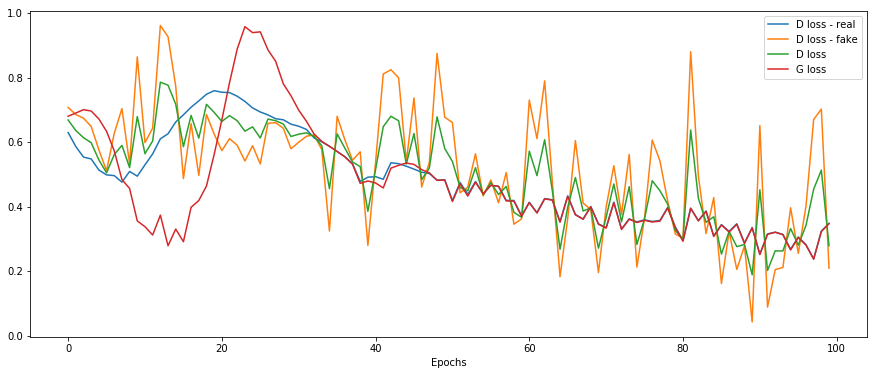

In [39]:
fig, ax = plt.subplots(figsize=(15, 6))
plt.plot(hist_d_loss_real)
plt.plot(hist_d_loss_fake)
plt.plot(hist_d_loss)
plt.plot(hist_g_loss)
ax.set_xlabel('Epochs')
ax.legend(['D loss - real', 
           'D loss - fake', 
           'D loss', 
           'G loss'])

In [40]:
generator.save_weights('gan_generator-model_weights.h5')
discriminator.save_weights('gan_discriminator-model_weights.h5')

In [41]:
def retrain_gan(adv, dis, gen, X_batch, y_batch):
    y_pred = gen.predict(X_batch)
            
    y_batch = y_batch.reshape((y_batch.shape[0], 1, n_outputs))
    y_pred = y_pred.reshape((y_pred.shape[0], 1, n_outputs))

    y_real = np.ones((y_batch.shape[0], 1))
    y_fake = np.zeros((y_pred.shape[0], 1))

    # Train discriminator
    dis.train_on_batch([X_batch, y_batch], y_real)
    dis.train_on_batch([X_batch, y_pred], y_fake)

    # Train generator
    adv.train_on_batch(X_batch, y_real)

In [42]:
# Walk Forward validation. Recursive Multi-step Forecast strategy
# See https://machinelearningmastery.com/multi-step-time-series-forecasting/
def GAN_walk_forward_validation(adv, dis, gen, 
                                train, test, 
                                size=1,
                                look_back=3, n_features=1, n_outputs=1):
    
    past = train.reshape(-1,).copy()
    future = test.reshape(-1,)[:size]
    
    predictions = list()
    limit_range = len(future)

    # For re-training
    generator.compile(optimizer=Adam(lr=0.00001), loss='mean_squared_error')
    
    for t in range(0, limit_range, n_outputs):
        x_input = past[-look_back:] # grab the last look_back days from the past
        
        preds_seq = []
        
        for p in range(n_outputs):
            y_output = gen.predict(x_input.reshape(1, look_back, n_features))
            
            y_output = y_output.reshape(-1,)
            
            # save the prediction in the sequence
            preds_seq.append(y_output)
            
            # get rid of the first input (first day look back)
            x_input = x_input[1:]
            
            # appends the new predicted one
            x_input = np.concatenate((x_input, y_output), axis=0)
        
        predicted = np.array(preds_seq).reshape(n_outputs,)
        predictions.append(predicted)

        # add the new n_outputs days (real ones) to the past
        past = np.concatenate((past, future[t:t+n_outputs]))
        
        if len(future[t:t+n_outputs]) == n_outputs:
            X_batch = x_input.reshape(1, look_back, n_features)
            y_batch = future[t:t+n_outputs].reshape(-1, n_outputs)
        
            # Time to re-train the model with the new non-seen days
            generator.train_on_batch(X_batch, y_batch)
            
    return np.array(predictions).reshape(-1,)[:limit_range]

In [44]:
size = 252 # approx. one year
steps = n_outputs
predictions = GAN_walk_forward_validation(adversarial, discriminator, generator, 
                                          scaled_train, scaled_test, size=size,
                                          look_back=look_back, n_outputs=steps)

In [45]:
from utils import plot_walk_forward_validation
from utils import plot_residual_forecast_error, print_performance_metrics

We need to revert the scaling and transformation:

In [50]:
descaled_preds = scaler.inverse_transform(predictions.reshape(-1, 1))
descaled_test = scaler.inverse_transform(scaled_test.reshape(-1, 1))

descaled_preds = inv_boxcox(descaled_preds, lmbda)
descaled_test = inv_boxcox(descaled_test, lmbda)

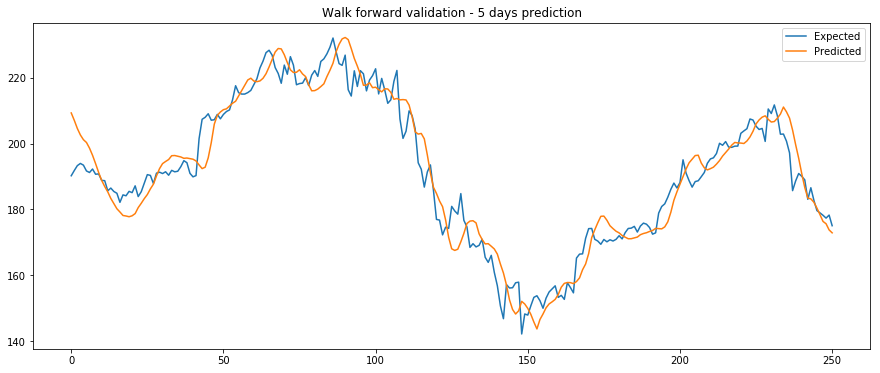

In [51]:
fig, ax = plt.subplots(figsize=(15, 6))
plt.plot(descaled_test[:size])
plt.plot(descaled_preds)
# plt.plot(scaled_test)
# plt.plot(predictions[:size])
ax.set_title('Walk forward validation - 5 days prediction')
ax.legend(['Expected', 'Predicted'])

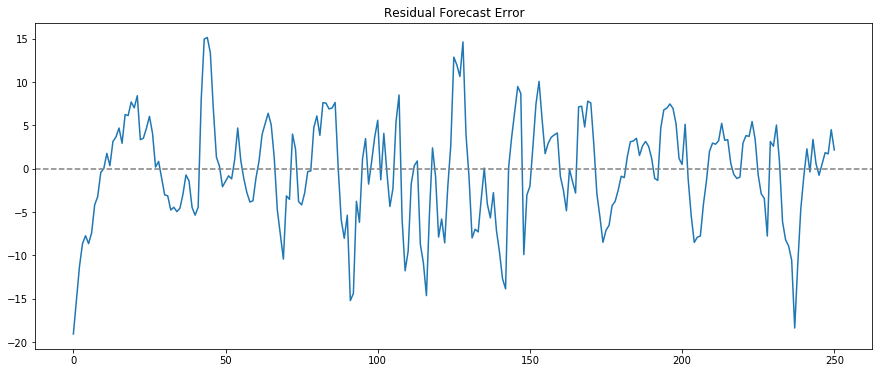

In [52]:
plot_residual_forecast_error(descaled_preds, descaled_test[:size])

In [53]:
print_performance_metrics(descaled_preds, 
                          descaled_test[:size],
                          model_name='GAN', 
                          total_days=size, steps=n_outputs)

GAN[252 days, 1 days forecast]:

Forecast Bias: -0.275
MAE: 4.757
MSE: 36.209
RMSE: 6.017
MAPE: 2.528


In [151]:
generator.load_weights('gan_generator-model_weights.h5')
discriminator.load_weights('gan_discriminator-model_weights.h5')